In [384]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from copy import deepcopy
import random
import mpmath as mp

In [1212]:
def norm(a):
    return a / np.linalg.norm(a)

def reconstruct(mps_in, ax=True):
    state_vec = []

    mps = deepcopy(mps_in)

    N = len(mps)

    # this converts to a different index order
    # where the physical index is the outermost index and the bond index is contained
    # also puts into canonical form we are used to seeing

    mps[-1] = np.swapaxes(mps[-1], 0, 1)
    for i in range(N-1):
        mps[i][0] = np.swapaxes(mps[i][0], 0, 1)


    for i in range(2**N):
        ind = [int(bit) for bit in format(i, '0{}b'.format(N))]
        prod = mps[-1][ind[-1]]
        for j in range(N-2, 0, -1):
            tensors = mps[j]
            prod = tensors[1] @ prod
            prod = tensors[0][ind[j]] @ prod
        prod = mps[0][1] @ prod
        prod = mps[0][0][:, ind[0]] @ prod
        state_vec.append(prod)
    return norm(state_vec)

def lcanonical(m):
    # this converts to a different index order
    # where the physical index is the outermost index and the bond index is contained
    # also puts into canonical form we are used to seeing
    mps = deepcopy(m)
    N = len(m)
    mps[-1] = np.swapaxes(mps[-1], 0, 1)
    for i in range(N-1):
        mps[i][0] = np.swapaxes(mps[i][0], 0, 1)
    r = []
    for i in range(len(mps)-1):
        r.append([mps[i][0][0] @ mps[i][1], mps[i][0][1] @ mps[i][1]])
    r.append(mps[-1])
    return r

def rcanonical(m):
    mps = deepcopy(m)
    N = len(m)
    mps[-1] = np.swapaxes(mps[-1], 0, 1)
    for i in range(N-1):
        mps[i][0] = np.swapaxes(mps[i][0], 0, 1)
    r = [mps[0][0]]
    for i in range(len(mps)-2):
        r.append([mps[i][1] @ mps[i+1][0][0], mps[i][1] @ mps[i+1][0][1]])
    r.append(mps[-2][1] @ mps[-1])
    return r

def form(m):
    state_vec = []

    mps = deepcopy(m)

    N = len(mps)

    for i in range(2**N):
        ind = [int(bit) for bit in format(i, '0{}b'.format(N))]
        prod = [[row[ind[-1]]] for row in mps[-1]]
        for j in range(N-2, -1, -1):
            prod = mps[j][ind[j]] @ prod

        state_vec.append(prod[0])

    return norm(state_vec)


def mps(state_v, chi=1000000):
    mps_v = []
    N = int(np.log2(len(state_v)))
    right = np.reshape(state_v, (2, 2**(N-1)))
    for i in range(N):
        if i == N-1:
            mps_v.append(right)
            continue
        gamma, S, right = np.linalg.svd(right, full_matrices=False)
        # left and right most gammas are our MPS caps, only have one bond index
        if i > 0 and i < N-1:
            if chi < len(S) and chi >= 1:
                gamma = gamma[:, :chi]
                S = S[:chi]
                right = right[:chi, :]

            gamma = np.reshape(gamma, (int(gamma.shape[0]/2), 2, gamma.shape[1]))

        # maybe we aren't reshaping things absolutely correctly, so symmetries make things seem to be working, but then things break with misplaced minus signs
        # don't want to reshape this way when there is only 1 column
        if right.shape[1] > 2:
            right = np.reshape(right, (int(right.shape[0]*2), int(right.shape[1]/2)))
        
        lambd = np.diag(norm(S))
        mps_v.append([gamma, lambd])

    return mps_v

def haar_state(N, complexv=True):
    # for some reason, when we use complex amplitudes the fidelity caps out at ~0.85
    # this is likely not an issue with the code, since manually creating simple complex
    # valued states leads to 1.0 fidelity. Instead, something about randomly generating
    # more complex states seems to mess the precision
    if not complexv:
        return norm(np.array([complex(np.random.normal(), 0) for _ in range(2**N)]))
    return norm(np.array([complex(np.random.normal(), np.random.normal()) for _ in range(2**N)]))
    # state = [complex(round(i.real, 1), round(i.imag, 1)) for i in state]

In [1221]:
def abs_real(vec):
    for i in range(len(vec)):
        if vec[i].real < 0:
            vec[i] = complex(-vec[i].real, vec[i].imag)
    return vec

def test_mps(N, trials, chi, complexv=True):
    avg = 0
    for i in range(trials):
        state = haar_state(N, complexv=complexv)
        m = mps(state, chi=chi)
        mps_v = reconstruct(m)
        avg += np.abs(np.dot(np.conjugate(state), mps_v))**2
    return avg / trials

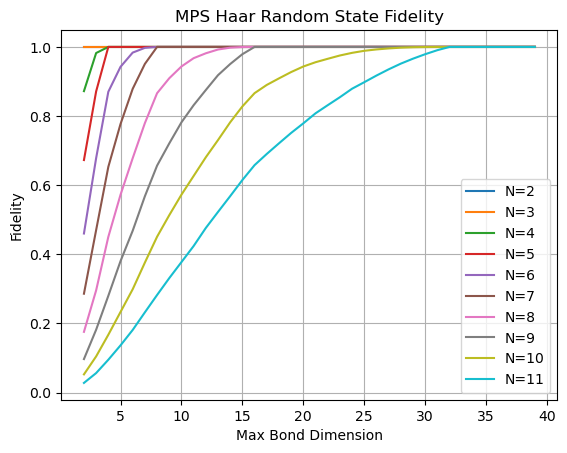

In [1224]:
data = []
N_array = np.linspace(2,11, num=10, dtype=int)
x = range(2, 40)
for N in N_array:
    line = []
    for i in x:
        line.append(test_mps(N=N, trials=45, chi=i))
    data.append(line)

for i, line in enumerate(data):
    plt.plot(x, line, label=f'N={N_array[i]}')

plt.xlabel('Max Bond Dimension')
plt.ylabel('Fidelity')
plt.title('MPS Haar Random State Fidelity')
plt.grid(True)
plt.legend()
plt.show()

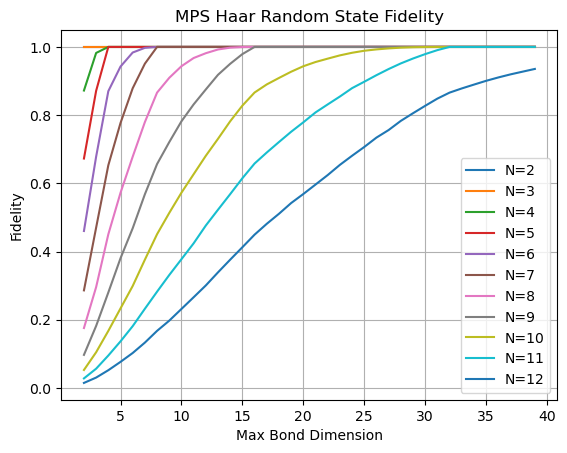